In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import os
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.metrics import Metric

2024-04-22 20:17:50.260729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 20:17:51.154451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_dir=r'data/split_dataset/train'
test_dir=r'data/split_dataset/test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation' 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 18741 images belonging to 2 classes.
Found 3306 images belonging to 2 classes.
Found 5514 images belonging to 2 classes.


In [4]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import ReLU

def depthwise_inception_resnet(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Inception-ResNet module
    def inception_resnet_block(x, scale=1.0):
        conv1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)

        conv2_1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        conv2_1 = DepthwiseConv2D(3, padding='same', activation='relu')(conv2_1)

        conv2_2 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        conv2_2 = DepthwiseConv2D(5, padding='same', activation='relu')(conv2_2)

        # Add max pooling layer after conv2_2
        maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(conv2_2)
        maxpool = Conv2D(32, (1, 1), padding='same', activation='relu')(maxpool)

        inception_block = Concatenate(axis=-1)([conv1, conv2_1,conv2_2, maxpool])

        # Residual connection
        scaled_block = Conv2D(int(x.shape[-1]), (1, 1), padding='same', activation='linear')(inception_block)
        scaled_block = BatchNormalization()(scaled_block)

        out = Add()([x, scaled_block])
        out = ReLU()(out * scale)

        return out

    # Initial convolution
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)

    # Depthwise Inception-ResNet blocks
    x = inception_resnet_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = inception_resnet_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = inception_resnet_block(x)
    x = MaxPooling2D(2, 2)(x)
    x = inception_resnet_block(x)
    x = MaxPooling2D(2, 2)(x)

    # Global average pooling and dense layers
    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Example usage
input_shape = (224, 224, 3)
num_classes = 2
model = depthwise_inception_resnet(input_shape, num_classes)

2024-04-22 20:18:13.263792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 20:18:13.277011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 20:18:13.277289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
import os
files = os.listdir('data/split_dataset/test/Parasitized')
print(files)  # 这将列出指定目录下的所有文件


['C99P60ThinF_IMG_20150918_141620_cell_46.png', 'C136P97ThinF_IMG_20151005_142437_cell_109.png', 'C130P91ThinF_IMG_20151004_141504_cell_154.png', 'C176P137NThinF_IMG_20151201_114035_cell_118.png', 'C71P32_ThinF_IMG_20150813_162146_cell_217.png', 'C42P5thin_original_IMG_20150623_135746_cell_161.png', 'C51AP12thinF_IMG_20150724_161126_cell_125.png', 'C180P141NThinF_IMG_20151201_165659_cell_24.png', 'C136P97ThinF_IMG_20151005_142627_cell_24.png', 'C59P20thinF_IMG_20150803_111244_cell_190.png', 'C154P115ThinF_IMG_20151115_141336_cell_234.png', 'C160P121ThinF_IMG_20151116_092925_cell_148.png', 'C182P143NThinF_IMG_20151201_172842_cell_1.png', 'C175P136NThinF_IMG_20151127_141428_cell_226.png', 'C148P109ThinF_IMG_20151115_112253_cell_222.png', 'C133P94ThinF_IMG_20151004_154919_cell_142.png', 'C59P20thinF_IMG_20150803_115303_cell_21.png', 'C184P145ThinF_IMG_20151203_103326_cell_163.png', 'C182P143NThinF_IMG_20151201_172257_cell_150.png', 'C182P143NThinF_IMG_20151201_171905_cell_183.png', 'C68P2

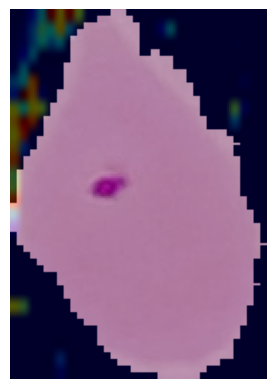

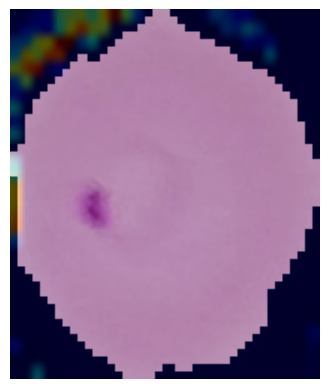

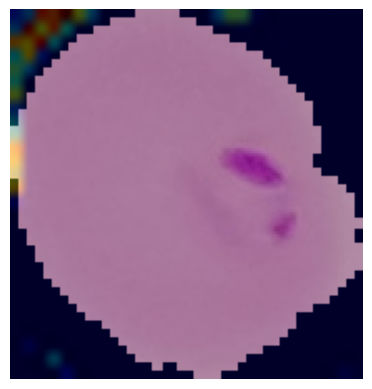

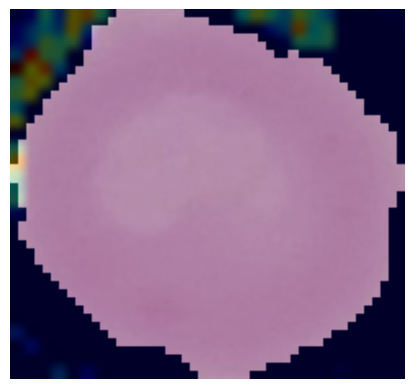

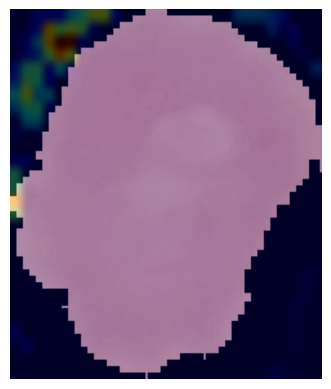

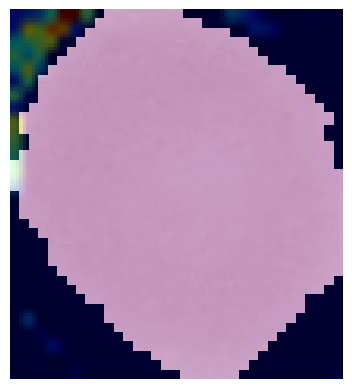

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array * 1./255  # Match the rescale factor used in ImageDataGenerator

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()
    return cam_path

# 示例使用
img_path = 'data/split_dataset/test/Parasitized/C101P62ThinF_IMG_20150918_151149_cell_68.png'
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_19', pred_index=0)  # 使用正确的层名称
cam_path = save_and_display_gradcam(img_path, heatmap)


img_path = 'data/split_dataset/test/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png'
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_19', pred_index=0)  # 使用正确的层名称
cam_path = save_and_display_gradcam(img_path, heatmap)

img_path = 'data/split_dataset/test/Parasitized/C100P61ThinF_IMG_20150918_144348_cell_143.png'
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_19', pred_index=0)  # 使用正确的层名称
cam_path = save_and_display_gradcam(img_path, heatmap)

img_path = 'data/split_dataset/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_131.png'
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_19', pred_index=0)  # 使用正确的层名称
cam_path = save_and_display_gradcam(img_path, heatmap)

img_path = 'data/split_dataset/test/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_108.png'
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_19', pred_index=0)  # 使用正确的层名称
cam_path = save_and_display_gradcam(img_path, heatmap)

img_path = 'data/split_dataset/test/Uninfected/C100P61ThinF_IMG_20150918_144823_cell_71.png'
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_19', pred_index=0)  # 使用正确的层名称
cam_path = save_and_display_gradcam(img_path, heatmap)
